In [409]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.profiler import profile, record_function, ProfilerActivity
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import json
import seaborn as sns
import time

## Data Preparation & Preprocessing

In [413]:
# Plot Price curve (ground truth data)
def plot_price_curve(data):
    plt.figure(figsize=(10, 5))
    plt.plot(data)
    plt.legend()
    plt.title('Prices Curve')
    # plt.ylim(-1, 1)
    plt.show()

In [416]:
class DataPreparation():
    def __init__(self, dataset_filename, num_steps=None, input_size=None, configs_filename='configs', seed=42):
        self.num_steps = num_steps
        self.input_size = input_size
        self.set_seed(seed)
        self.load_configs(configs_filename)
        self.load_data(dataset_filename)
        
    def set_seed(self, seed):
        np.random.seed(seed)  # Set seed for numpy
        random.seed(seed)  # Set seed for random
        
        if torch.cuda.is_available():
            torch.manual_seed(seed)  # Set seed for PyTorch CPU
        
        torch.cuda.manual_seed(seed)  # Set seed for PyTorch GPU
        torch.cuda.manual_seed_all(seed)  # Set seed for all GPUs
        torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for CUDA
        torch.backends.cudnn.benchmark = False  # Disable the auto-tuner for GPUs
    
    def load_configs(self, configs_filename):
        # Load hyperparameters
        with open(f'configs/{configs_filename}.json', 'r') as file:
            self.hyperparams = json.load(file)
            
    def load_data(self, dataset_filename):
        self.data = pd.read_csv('data/' + dataset_filename + '.csv')
        # self.data = self.data.resample(period).mean()  # Resample data based on the period
        
        # Extract attributes
        if self.num_steps is None:
            self.num_steps = self.hyperparams['num_steps']  # Extract number of steps
        
        if self.input_size is None:
            self.input_size = self.hyperparams['input_size']  # Extract input size
        
        self.val_split = self.hyperparams['val_split']  # Extract validation split
        self.test_split = self.hyperparams['test_split']  # Extract test split
        self.batch_size = self.hyperparams['batch_size'] # Extract batch size
        self.num_workers = self.hyperparams['num_workers'] # Extract number of workers (for GPU)
        self.volume_threshold = self.hyperparams['volume_threshold'] # Extract volume threshold (for main contract)
        self.open_interest_threshold = self.hyperparams['open_interest_threshold'] # Extract open interest threshold (for main contract)
        self.time_interval = self.hyperparams['time_interval'] # Extract time interval of data (in seconds)
        self.normalize = self.hyperparams['normalize']
        
        # Extract main contract
        self.data = extract_high_frequency_trading(self.data, volume_threshold=self.volume_threshold, open_interest_threshold=self.open_interest_threshold, time_interval=self.time_interval)
        
        # Normalize data
        self.data = self.normalize_data(self.data)

        # Assert no NaN values
        assert(self.data.isna().sum().sum() == 0)

        # Create sequences (with sliding windows)
        X_train, y_train, X_val, y_val, X_test, y_test = self.create_sequences(self.data, self.input_size, self.num_steps, self.val_split, self.test_split)
        
        # Convert to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
        
        assert(not torch.isnan(X_train_tensor).any())
        assert(not torch.isnan(y_train_tensor).any())
        assert(not torch.isnan(X_val_tensor).any())
        assert(not torch.isnan(y_val_tensor).any())
        assert(not torch.isnan(X_test_tensor).any())
        assert(not torch.isnan(y_test_tensor).any())
        
        # Create DataLoader instances
        self.train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, pin_memory=True)
        self.val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)
        self.test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)

    def normalize_data(self, data):
        # Apply MinMaxScaler to normalize data
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(data)
        return pd.DataFrame(normalized_data, index=data.index, columns=data.columns)
    
    def create_sequences(self, data, input_size, num_steps, val_split=0.1, test_split=0.1):
        # Convert data to numpy array
        data = np.array(data)
    
        # Roll data
        data = [np.array(data[i * input_size: (i + 1) * input_size]) 
           for i in range(len(data) // input_size)]
    
        # Convert data to numpy array
        data = np.array(data)
    
        # Check if data has any NaNs
        if np.isnan(data).any():
            raise ValueError("Data contains NaN values. Please clean the data before proceeding.")
    
        # Replace zeros in the last price with a small value to avoid division by zero
        last_price_index = 0
        data[:, :, last_price_index] = np.where(data[:, :, last_price_index] == 0, 1e-6, data[:, :, last_price_index])  # Small constant to avoid division by zero
    
        # Normalize the last_price (predict relative change rates)
        if self.normalize:
            normalized_last_price = [data[0, :, last_price_index] / data[0, 0, last_price_index] - 1.0]  # Initial normalization
            
            for i in range(1, data.shape[0]):
                normalized_last_price.append(data[i, :, last_price_index] / data[i-1, -1, last_price_index] - 1.0)
            
            normalized_last_price = np.array(normalized_last_price)

            # Remove outliers
            normalized_last_price = np.clip(normalized_last_price, -1, 1)
            
            data[:, :, last_price_index] = normalized_last_price
    
        plot_price_curve(data[:, :, last_price_index])
    
        # Check for remaining NaNs after normalization
        if np.isnan(data[:, :, last_price_index]).any():
            raise ValueError("Data contains NaN values after normalization. Please check the normalization process.")
    
        # Split into groups of `num_steps`
        X = np.array([data[i: i + num_steps] for i in range(len(data) - num_steps)])
        assert(X.shape == (len(X), num_steps, input_size, data.shape[-1]))
        y = np.array([data[i + num_steps, :, last_price_index] for i in range(len(data) - num_steps)])
        assert(y.shape == (len(X), input_size))
    
        self.num_features = data.shape[-1]
    
        # Ensure X and y have the same number of samples after splitting
        assert len(X) == len(y), "Number of samples in X and y must be equal"
    
        # Split into train, validation, and test sets
        total_len = len(X)
        test_start = int(total_len * (1 - test_split))
        val_start = int(total_len * (1 - test_split - val_split))
    
        X_train, X_val, X_test = X[:val_start], X[val_start:test_start], X[test_start:]
        y_train, y_val, y_test = y[:val_start], y[val_start:test_start], y[test_start:]
    
        return X_train, y_train, X_val, y_val, X_test, y_test

def extract_continuous_segment(data, volume_threshold, open_interest_threshold, time_interval):
    """
    Extracts the largest continuous segment from high-frequency data based on given thresholds and time interval.
    
    Args:
    data (pd.DataFrame): High-frequency data containing 'Timestamp', 'Volume', and 'OpenInterest' columns.
    volume_threshold (int): Minimum volume threshold.
    open_interest_threshold (int): Minimum open interest threshold.
    time_interval (float): Maximum allowable time difference between consecutive data points (in seconds).

    Returns:
    pd.DataFrame: Continuous segment of the main contract data.
    """
    # Step 1: Remove rows with NaN values
    cleaned_data = data.dropna()

    # Step 2: Apply volume and open interest thresholds
    filtered_data = cleaned_data[(cleaned_data['volume'] >= volume_threshold) & 
                                 (cleaned_data['open_interest'] >= open_interest_threshold)]
    
    # Step 3: Identify continuous segments
    filtered_data = filtered_data.sort_values(by='datetime')

    # Calculate time differences between consecutive rows
    filtered_data['datetime_diff'] = filtered_data['datetime'].diff().dt.total_seconds()

    # Identify segments where the time difference is larger than the time_interval threshold
    filtered_data['segment'] = (filtered_data['datetime_diff'] > time_interval).cumsum()

    # Find the length of each segment
    segment_lengths = filtered_data['segment'].value_counts()

    # Extract the largest segment
    largest_segment = segment_lengths.idxmax()
    continuous_data = filtered_data[filtered_data['segment'] == largest_segment]

    # Drop the temporary columns
    continuous_data = continuous_data.drop(columns=['datetime_diff', 'segment'])

    return continuous_data


def extract_high_frequency_trading(data, volume_threshold=1000, open_interest_threshold=500, time_interval=1):
    # Convert datetime column to pandas datetime type
    data['datetime'] = pd.to_datetime(data['datetime'])
    
    # Identify high-frequency trading periods
    # Assuming a significant increase in volume and consistent bid/ask prices indicates high-frequency trading
    # Adjust the thresholds as necessary for your dataset
    high_freq_trading = data[
        (data['volume'] > volume_threshold) & 
        (data['open_interest'] > open_interest_threshold) & 
        (data['last_price'].notna()) & 
        (data['highest'].notna()) & 
        (data['volume'].notna()) & 
        (data['amount'].notna()) & 
        (data['bid_price1'].notna()) & 
        (data['ask_price1'].notna())
    ]

    # Additional filter to ensure high-frequency (optional)
    # Extract largest continuous segment of high-frequency trading data
    high_freq_trading = extract_continuous_segment(high_freq_trading, volume_threshold, open_interest_threshold, time_interval)
    high_freq_trading = high_freq_trading.set_index('datetime')
    
    # Ensure No NaN values remaining
    assert(high_freq_trading.isna().sum().sum() == 0)
    
    # Return the filtered dataset
    return high_freq_trading

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


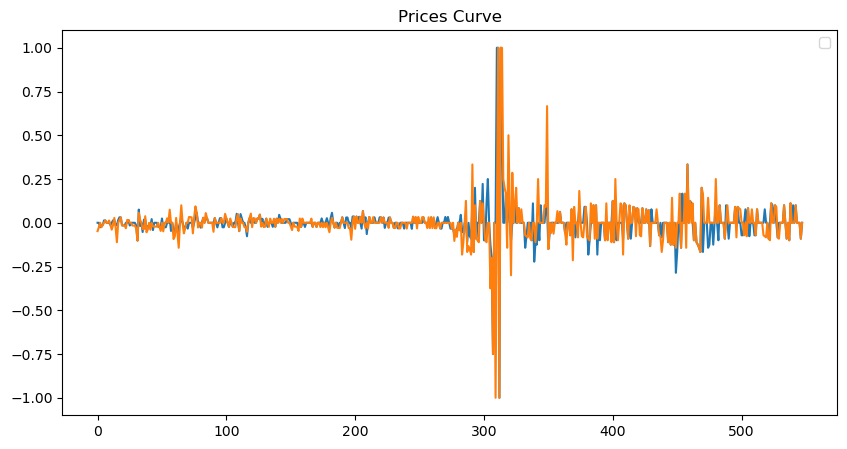

In [417]:
dataset_name = 'INE.sc2010'
data_preparation = DataPreparation(dataset_name) 

## Model Definition: LSTM Cell

In [418]:
class CustomLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(CustomLSTMCell, self).__init__()
        self.hidden_dim = hidden_dim

        # Initialize weights and biases
        self.W_i = nn.Parameter(torch.randn(input_size, hidden_dim).float())
        self.U_i = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_i = nn.Parameter(torch.zeros(hidden_dim).float())

        self.W_f = nn.Parameter(torch.randn(input_size, hidden_dim).float())
        self.U_f = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_f = nn.Parameter(torch.zeros(hidden_dim).float())
        
        self.W_c = nn.Parameter(torch.randn(input_size, hidden_dim).float())
        self.U_c = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_c = nn.Parameter(torch.zeros(hidden_dim).float())
        
        self.W_o = nn.Parameter(torch.randn(input_size, hidden_dim).float())
        self.U_o = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_o = nn.Parameter(torch.zeros(hidden_dim).float())
        
        # Layer normalization layers
        self.ln_i = nn.LayerNorm(hidden_dim)
        self.ln_f = nn.LayerNorm(hidden_dim)
        self.ln_c = nn.LayerNorm(hidden_dim)
        self.ln_o = nn.LayerNorm(hidden_dim)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'W_' in name or 'U_' in name:
                nn.init.orthogonal_(param)  # Use orthogonal initialization
            elif 'b_' in name:
                nn.init.constant_(param, 0.0)

            # Check for NaN values
            assert(not torch.isnan(param).any())

    def forward(self, x, h, c):
        # Compute gates
        i_t = torch.sigmoid(self.ln_i(torch.matmul(x, self.W_i) + torch.matmul(h, self.U_i) + self.b_i))
        f_t = torch.sigmoid(self.ln_f(torch.matmul(x, self.W_f) + torch.matmul(h, self.U_f) + self.b_f))
        g_t = torch.tanh(self.ln_c(torch.matmul(x, self.W_c) + torch.matmul(h, self.U_c) + self.b_c))
        o_t = torch.sigmoid(self.ln_o(torch.matmul(x, self.W_o) + torch.matmul(h, self.U_o) + self.b_o))

        # Compute cell and hidden state
        c_t = f_t * c + i_t * g_t
        h_t = o_t * torch.tanh(c_t)
        
        assert(not torch.isnan(h_t).any())
        assert(not torch.isnan(c_t).any())
        
        return h_t, c_t

## Model Definition: GRU Cell

In [419]:
class CustomGRUCell(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(CustomGRUCell, self).__init__()
        self.hidden_dim = hidden_dim

        # Initialize weights and biases
        self.W_z = nn.Parameter(torch.randn(input_size, hidden_dim).float())
        self.U_z = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_z = nn.Parameter(torch.zeros(hidden_dim).float())

        self.W_r = nn.Parameter(torch.randn(input_size, hidden_dim).float())
        self.U_r = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_r = nn.Parameter(torch.zeros(hidden_dim).float())
        
        self.W_h = nn.Parameter(torch.randn(input_size, hidden_dim).float())
        self.U_h = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_h = nn.Parameter(torch.zeros(hidden_dim).float())
        
        # Layer normalization layers
        self.ln_z = nn.LayerNorm(hidden_dim)
        self.ln_r = nn.LayerNorm(hidden_dim)
        self.ln_h = nn.LayerNorm(hidden_dim)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'W_' in name or 'U_' in name:
                nn.init.xavier_uniform_(param)  # Use orthogonal initialization
            elif 'b_' in name:
                nn.init.constant_(param, 0.0)

            # Check for NaN values
            assert(not torch.isnan(param).any())

    def forward(self, x, h):
        z_t = torch.sigmoid(self.ln_z(torch.mm(x, self.W_z) + torch.mm(h, self.U_z) + self.b_z))
        r_t = torch.sigmoid(self.ln_r(torch.mm(x, self.W_r) + torch.mm(h, self.U_r) + self.b_r))
        h_hat_t = torch.tanh(self.ln_h(torch.mm(x, self.W_h) + torch.mm(r_t * h, self.U_h) + self.b_h))

        h_t = (1 - z_t) * h + z_t * h_hat_t
        
        assert(not torch.isnan(h_t).any())
    
        return h_t

## Model Definition: RNN

In [420]:
class CustomRNNModel(nn.Module):
    def __init__(self, input_size, num_features, hidden_dim, output_dim, num_layers, dropout_rate, dense_units, cell_type='lstm'):
        super(CustomRNNModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.cell_type = cell_type
        self.input_dim = input_size * num_features

        if cell_type == 'lstm':
            self.layers = nn.ModuleList([CustomLSTMCell(self.input_dim, hidden_dim)])
            self.layers.extend([CustomLSTMCell(hidden_dim, hidden_dim) for _ in range(num_layers - 1)])
        elif cell_type == 'gru':
            self.layers = nn.ModuleList([CustomGRUCell(self.input_dim, hidden_dim)])
            self.layers.extend([CustomGRUCell(hidden_dim, hidden_dim) for _ in range(num_layers - 1)])
        else:
            raise ValueError("Unsupported cell type")

        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_dim, dense_units)
        self.fc2 = nn.Linear(dense_units, output_dim)

    def forward(self, x):
        batch_size, num_steps, input_size, num_features = x.size()
        x = x.view(batch_size, num_steps, -1)  # Flatten the input dimensions to (batch_size, num_steps, input_size * num_features)

        h_t = [torch.zeros(batch_size, self.hidden_dim, device=x.device) for _ in range(self.num_layers)]
        if self.cell_type == 'lstm':
            c_t = [torch.zeros(batch_size, self.hidden_dim, device=x.device) for _ in range(self.num_layers)]

        for t in range(num_steps):
            x_t = x[:, t, :]
            for layer in range(self.num_layers):
                if self.cell_type == 'lstm':
                    h_t[layer], c_t[layer] = self.layers[layer](x_t, h_t[layer], c_t[layer])
                else:
                    h_t[layer] = self.layers[layer](x_t, h_t[layer])
                x_t = h_t[layer]

        x = self.dropout(x_t)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

## RNN Model Training + Evaluation

In [421]:
# Loss definitions
def quantile_loss(outputs, targets, quantile=0.5):
    errors = targets - outputs
    loss = torch.max((quantile - 1) * errors, quantile * errors)
    return torch.mean(loss)


class HingeLoss(nn.Module):
    def __init__(self):
        super(HingeLoss, self).__init__()

    def forward(self, outputs, targets):
        return torch.mean(torch.clamp(1 - targets * outputs, min=0))


def directional_loss(outputs, targets):
    return torch.mean(torch.abs(torch.sign(outputs) - torch.sign(targets)))


def choose_loss_function(loss, quantile=None):
    if loss == 'huber':
        criterion = nn.SmoothL1Loss()
    elif loss == 'mse':
        criterion = nn.MSELoss()
    elif loss == 'quantile' and quantile is not None:
        criterion = lambda outputs, targets: quantile_loss(outputs, targets, quantile=quantile)
    elif loss == 'hinge':
        criterion = HingeLoss()
    elif loss == 'directional':
        criterion = directional_loss
    else:
        raise ValueError("Unsupported loss function")

    return criterion

In [422]:
class ModelTrainer:
    def __init__(self, data_preparation, cell_type):
        self.data_preparation = data_preparation
        self.cell_type = cell_type

    def extract_hyperparams(self):
        dp = self.data_preparation
        cell_type = self.cell_type
        num_units = dp.hyperparams[cell_type][cell_type + '_units']
        num_layers = dp.hyperparams[cell_type][cell_type + '_layers']
        dropout_rate = dp.hyperparams[cell_type]['dropout_rate']
        dense_units = dp.hyperparams[cell_type]['dense_units']
        init_learning_rate = dp.hyperparams[cell_type]['init_learning_rate']
        learning_rate_decay = dp.hyperparams[cell_type]['learning_rate_decay']
        init_epochs = dp.hyperparams[cell_type]['init_epochs']
        max_epochs = dp.hyperparams[cell_type]['max_epochs']
        early_stop_patience = dp.hyperparams[cell_type].get('early_stop_patience', None)
        train_needed = dp.hyperparams[cell_type]['pretrain']
        
        return num_units, num_layers, dropout_rate, dense_units, init_learning_rate, learning_rate_decay, init_epochs, max_epochs, early_stop_patience, train_needed

    def train_model(self, model, train_loader, val_loader, criterion, init_epochs, num_epochs, init_learning_rate, learning_rate_decay, device, early_stop_patience=None):
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        early_stop_counter = 0
    
        optimizer = optim.Adam(model.parameters(), lr=init_learning_rate)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.0)
    
        for epoch in range(num_epochs):
            model.train()
            current_lr = init_learning_rate * (learning_rate_decay ** max(float(epoch + 1 - init_epochs), 0.0))
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr
                
            train_loss = 0.0
            for X_batch, y_batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
    
                train_loss += loss.item()
    
            train_loss /= len(train_loader)
            train_losses.append(train_loss)
    
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    outputs = model(X_batch)
                    val_loss += criterion(outputs, y_batch).item()
    
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
    
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
            scheduler.step()
    
            if early_stop_patience is not None:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    early_stop_counter = 0
                    torch.save(model.state_dict(), f'models/SP500_{self.cell_type}_model.pth')
                else:
                    early_stop_counter += 1
                    if early_stop_counter >= early_stop_patience:
                        print("Early stopping triggered")
                        break
    
        return train_losses, val_losses

    def train(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        num_units, num_layers, dropout_rate, dense_units, init_learning_rate, learning_rate_decay, init_epochs, max_epochs, early_stop_patience, train_needed = self.extract_hyperparams()
        num_features = self.data_preparation.num_features
        input_size = self.data_preparation.input_size

        model = CustomRNNModel(input_size=input_size, num_features=num_features, hidden_dim=num_units, output_dim=input_size, num_layers=num_layers, dropout_rate=dropout_rate, dense_units=dense_units, cell_type=self.cell_type)
        model.to(device)
        
        if train_needed: 
            criterion = choose_loss_function('mse')
    
            start_time = time.time()
            train_losses, val_losses = self.train_model(model, self.data_preparation.train_loader, self.data_preparation.val_loader, criterion, init_epochs, max_epochs, init_learning_rate, learning_rate_decay, device, early_stop_patience)
            duration = time.time() - start_time
            torch.save(model.state_dict(), f'models/SP500_{cell_type}_model.pth')
        else:
            # Load the model
            model = self.load_model(model, cell_type, device)
            print("Model loaded successfully")

        # Plot train and validation loss curves
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.legend()
        plt.title('Loss Curves')
        plt.show()

        return model, duration

In [423]:
class ModelPredictor:
    def __init__(self, model, data_preparation, cell_type):
        self.model = model
        self.data_preparation = data_preparation
        self.cell_type = cell_type

    def make_predictions(self, model, data_loader, device):
        model.eval()
        predictions = []
        actuals = []
        test_loss = 0
        criterion = choose_loss_function('mse')
        
        with torch.no_grad():
            for X_batch, y_batch in data_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                predictions.append(outputs.cpu().numpy())
                actuals.append(y_batch.cpu().numpy())
                test_loss += criterion(outputs, y_batch).item()

        test_loss /= len(data_loader)
        predictions = np.concatenate(predictions)
        actuals = np.concatenate(actuals)
        return np.array(predictions).flatten(), np.array(actuals).flatten(), test_loss

    def calculate_accuracy(self, predictions, actuals):
        correct = np.sum(np.sign(predictions) == np.sign(actuals))
        print("correct:", correct)
        total = len(actuals.flatten())
        print("total:", total)
        accuracy = correct / total
        return accuracy

     # Plot the predictions against the actual values
    def plot_results(self, data_preparation, actuals, predictions):
        plt.figure(figsize=(10, 5))
        x = np.arange(len(actuals))
        plt.bar(x - 0.2, actuals, label='Actual Prices')
        plt.bar(x + 0.2, predictions, label='Predicted Prices')
        plt.xlabel('Value')
        plt.ylabel('Normalized Price')
        plt.ylim(-0.1, 0.1)
        plt.title(f'Predicted vs Actual Prices for input_size={data_preparation.input_size}, num_steps={data_preparation.num_steps}')
        plt.legend()
        plt.show()

    def predict(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        
        predictions, actuals, test_loss = self.make_predictions(self.model, self.data_preparation.test_loader, device)

        print("predictions:", predictions[0:5])
        print("actuals:", actuals[0:5])
        
        classification_accuracy = self.calculate_accuracy(predictions, actuals)
        self.plot_results(self.data_preparation, predictions, actuals)
        
        return test_loss, classification_accuracy

In [424]:
cell_type = 'lstm'

Epoch 1/50, Train Loss: 0.0494, Val Loss: 0.0346


Epoch 2/50, Train Loss: 0.0396, Val Loss: 0.0279


Epoch 3/50, Train Loss: 0.0326, Val Loss: 0.0230


Epoch 4/50, Train Loss: 0.0272, Val Loss: 0.0192


Epoch 5/50, Train Loss: 0.0235, Val Loss: 0.0163


Epoch 6/50, Train Loss: 0.0212, Val Loss: 0.0141


Epoch 7/50, Train Loss: 0.0183, Val Loss: 0.0127


Epoch 8/50, Train Loss: 0.0171, Val Loss: 0.0120


Epoch 9/50, Train Loss: 0.0174, Val Loss: 0.0116


Epoch 10/50, Train Loss: 0.0178, Val Loss: 0.0114


Epoch 11/50, Train Loss: 0.0170, Val Loss: 0.0114


Epoch 12/50, Train Loss: 0.0175, Val Loss: 0.0114


Epoch 13/50, Train Loss: 0.0170, Val Loss: 0.0113


Epoch 14/50, Train Loss: 0.0167, Val Loss: 0.0114


Epoch 15/50, Train Loss: 0.0175, Val Loss: 0.0114


Epoch 16/50, Train Loss: 0.0166, Val Loss: 0.0114


Epoch 17/50, Train Loss: 0.0163, Val Loss: 0.0114


Epoch 18/50, Train Loss: 0.0167, Val Loss: 0.0114


Epoch 19/50, Train Loss: 0.0164, Val Loss: 0.0113


Epoch 20/50, Train Loss: 0.0164, Val Loss: 0.0113


Epoch 21/50, Train Loss: 0.0164, Val Loss: 0.0113


Epoch 22/50, Train Loss: 0.0166, Val Loss: 0.0113


Epoch 23/50, Train Loss: 0.0159, Val Loss: 0.0113


Epoch 24/50, Train Loss: 0.0165, Val Loss: 0.0113


Epoch 25/50, Train Loss: 0.0157, Val Loss: 0.0112


Epoch 26/50, Train Loss: 0.0164, Val Loss: 0.0112


Epoch 27/50, Train Loss: 0.0164, Val Loss: 0.0112


Epoch 28/50, Train Loss: 0.0157, Val Loss: 0.0112


Epoch 29/50, Train Loss: 0.0161, Val Loss: 0.0112


Epoch 30/50, Train Loss: 0.0159, Val Loss: 0.0112


Epoch 31/50, Train Loss: 0.0159, Val Loss: 0.0112


Epoch 32/50, Train Loss: 0.0155, Val Loss: 0.0112


Epoch 33/50, Train Loss: 0.0157, Val Loss: 0.0112


Epoch 34/50, Train Loss: 0.0152, Val Loss: 0.0113


Epoch 35/50, Train Loss: 0.0158, Val Loss: 0.0113


Epoch 36/50, Train Loss: 0.0153, Val Loss: 0.0113


Epoch 37/50, Train Loss: 0.0156, Val Loss: 0.0113


Epoch 38/50, Train Loss: 0.0160, Val Loss: 0.0114


Epoch 39/50, Train Loss: 0.0152, Val Loss: 0.0114


Epoch 40/50, Train Loss: 0.0151, Val Loss: 0.0114


Epoch 41/50, Train Loss: 0.0152, Val Loss: 0.0114


Epoch 42/50, Train Loss: 0.0157, Val Loss: 0.0114


Epoch 43/50, Train Loss: 0.0155, Val Loss: 0.0114
Early stopping triggered


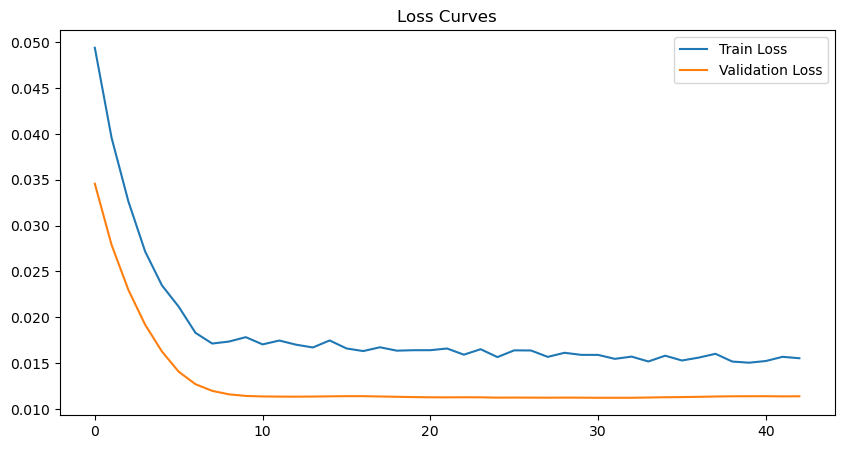

Training duration: 200.9986128807068 seconds


In [425]:
# Training
trainer = ModelTrainer(data_preparation, cell_type)
trained_model, training_duration = trainer.train()
print(f"Training duration: {training_duration} seconds")

predictions: [-0.02609026 -0.0039654  -0.0251216  -0.00345549 -0.02437857]
actuals: [0.         0.         0.         0.         0.09090909]
correct: 23
total: 110


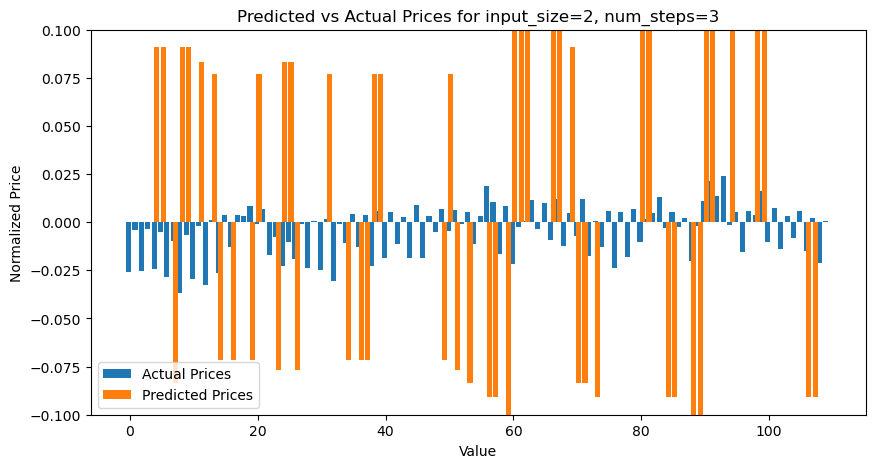

Test loss: 0.0038604720029979944
Classification accuracy: 0.20909090909090908


In [426]:
# Prediction
predictor = ModelPredictor(trained_model, data_preparation, cell_type)
test_loss, classification_accuracy = predictor.predict()
print(f"Test loss: {test_loss}")
print(f"Classification accuracy: {classification_accuracy}")

In [427]:
cell_type = 'gru'

Epoch 1/50, Train Loss: 0.0361, Val Loss: 0.0191


Epoch 2/50, Train Loss: 0.0244, Val Loss: 0.0160


Epoch 3/50, Train Loss: 0.0208, Val Loss: 0.0137


Epoch 4/50, Train Loss: 0.0180, Val Loss: 0.0122


Epoch 5/50, Train Loss: 0.0172, Val Loss: 0.0116


Epoch 6/50, Train Loss: 0.0178, Val Loss: 0.0115


Epoch 7/50, Train Loss: 0.0168, Val Loss: 0.0115


Epoch 8/50, Train Loss: 0.0169, Val Loss: 0.0116


Epoch 9/50, Train Loss: 0.0176, Val Loss: 0.0116


Epoch 10/50, Train Loss: 0.0167, Val Loss: 0.0116


Epoch 11/50, Train Loss: 0.0168, Val Loss: 0.0116


Epoch 12/50, Train Loss: 0.0165, Val Loss: 0.0116


Epoch 13/50, Train Loss: 0.0171, Val Loss: 0.0116


Epoch 14/50, Train Loss: 0.0167, Val Loss: 0.0116


Epoch 15/50, Train Loss: 0.0161, Val Loss: 0.0116


Epoch 16/50, Train Loss: 0.0158, Val Loss: 0.0116
Early stopping triggered


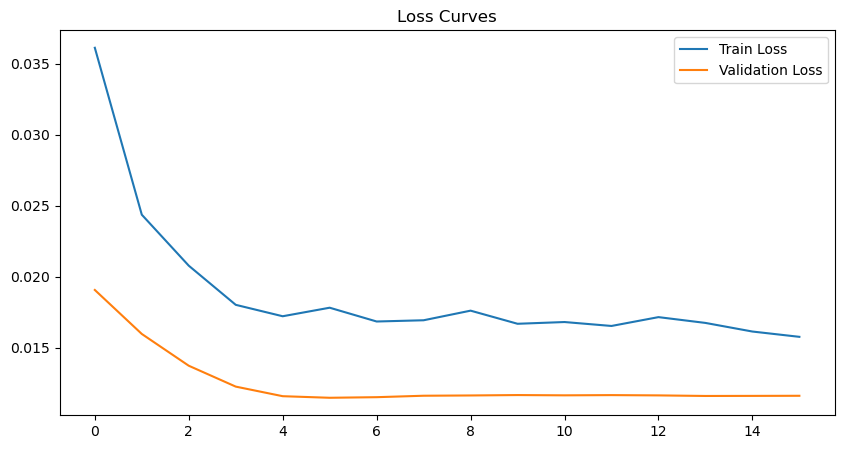

Training duration: 73.83038425445557 seconds


In [428]:
# Training
trainer = ModelTrainer(data_preparation, cell_type)
trained_model, training_duration = trainer.train()
print(f"Training duration: {training_duration} seconds")

predictions: [-0.01642713 -0.02795684 -0.01592278 -0.02518059 -0.01439801]
actuals: [0.         0.         0.         0.         0.09090909]
correct: 22
total: 110


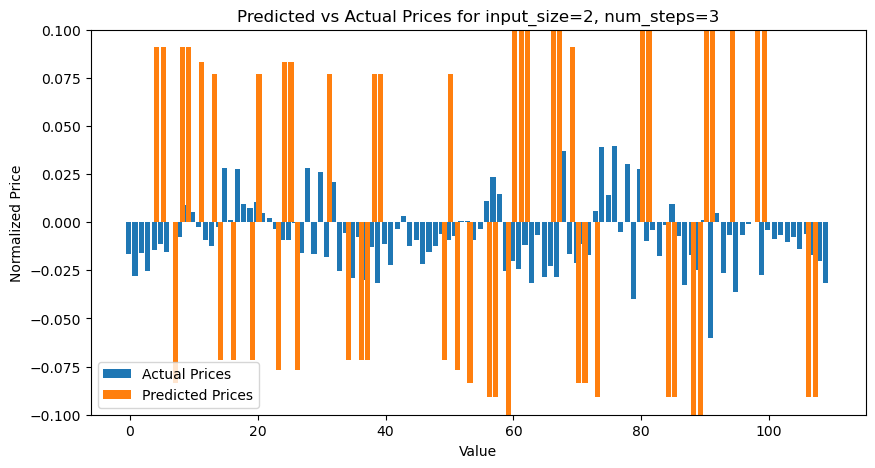

Test loss: 0.0043150256387889385
Classification accuracy: 0.2


In [429]:
# Prediction
predictor = ModelPredictor(trained_model, data_preparation, cell_type)
test_loss, classification_accuracy = predictor.predict()
print(f"Test loss: {test_loss}")
print(f"Classification accuracy: {classification_accuracy}")

## Hyperparameter Search over `input_size` and `num_steps`

In [ ]:
def grid_search(cell_type, input_size_values, num_steps_values):
    # Define dataframe
    df = pd.DataFrame(columns=['Input Size', 'Number of Steps', 'Test Loss', 'Classification Accuracy', 'Duration'])
    
    # Define test losses & classification accuracies
    input_size_combination_values = []
    num_steps_combination_values = []

    # Define hyperparam combinations
    test_losses = []
    classification_accuracies = []
    durations = []
    
    # Loop over the hyperparam values
    for input_size in input_size_values:
        for num_steps in num_steps_values:
            # Add to hyperparam combination
            input_size_combination_values.append(input_size)
            num_steps_combination_values.append(num_steps)
            
            # Modify the input_size and num_steps attributes
            data_preparation = DataPreparation(dataset_name, num_steps=num_steps, input_size=input_size)
            
            # Training
            trainer = ModelTrainer(data_preparation, cell_type)
            trained_model, training_duration = trainer.train()

            # Prediction
            predictor = ModelPredictor(trained_model, data_preparation, cell_type)
            test_loss, classification_accuracy = predictor.predict()
            
            test_losses.append(test_loss)
            classification_accuracies.append(classification_accuracy)   
            durations.append(training_duration)
    
    df['Input Size'] = input_size_combination_values
    df['Number of Steps'] = num_steps_combination_values
    df['Test Loss'] = test_losses
    df['Classification Accuracy'] = classification_accuracies
    df['Duration'] = durations
    
    df.to_csv(f'results/{cell_type}_evaluation_results.csv')

In [ ]:
def get_best_model(cell_type, input_size_values, num_steps_values, SEARCH_NEEDED=False):
    # Perform grid search if needed (setting SEARCH_NEEDED = TRUE will RUN LONG TIME!!!)
    if SEARCH_NEEDED:
        grid_search(cell_type, input_size_values, num_steps_values)
    
    # Get best model
    df = pd.read_csv(f'results/{cell_type}_evaluation_results.csv')
    idx = np.argmin(df['Test Loss'])
    df_best_model = df.iloc[idx, :]
    return df_best_model

In [ ]:
input_size_values = [2, 3, 5, 10, 20]
num_steps_values = [3, 10, 20, 30, 40, 50]

In [ ]:
# LSTM (setting SEARCH_NEEDED = TRUE will RUN LONG TIME!!!)
cell_type = 'lstm'
SEARCH_NEEDED_LSTM = True
df_best_model = get_best_model(cell_type, input_size_values, num_steps_values, SEARCH_NEEDED=SEARCH_NEEDED_LSTM)

In [ ]:
df_best_model

In [ ]:
# Modify the input_size and num_steps attributes
data_preparation = DataPreparation(dataset_name, num_steps=int(df_best_model['Number of Steps']), input_size=int(df_best_model['Input Size']))

# Training
trainer = ModelTrainer(data_preparation, cell_type)
trained_model, training_duration = trainer.train()

# Prediction
predictor = ModelPredictor(trained_model, data_preparation, cell_type)
test_loss, classification_accuracy = predictor.predict()

print("Test loss of best model:", test_loss)
print("Classification accuracy of best model:", classification_accuracy)
print("Duration of best model:", training_duration)

In [ ]:
# GRU (setting SEARCH_NEEDED = TRUE will RUN LONG TIME!!!)
cell_type = 'gru'
SEARCH_NEEDED_GRU = True
df_best_model = get_best_model(cell_type, input_size_values, num_steps_values, SEARCH_NEEDED=SEARCH_NEEDED_GRU)

In [ ]:
df_best_model

In [ ]:
# Modify the input_size and num_steps attributes
data_preparation = DataPreparation(dataset_name, num_steps=int(df_best_model['Number of Steps']), input_size=int(df_best_model['Input Size']))

# Training
trainer = ModelTrainer(data_preparation, cell_type)
trained_model, training_duration = trainer.train()

# Prediction
predictor = ModelPredictor(trained_model, data_preparation, cell_type)
test_loss, classification_accuracy = predictor.predict()

print("Test loss of best model:", test_loss)
print("Classification accuracy of best model:", classification_accuracy)
print("Duration of best model:", training_duration)

m1/lib/python3.8/site-packages/torch/nn/__init__.py", line 1, in <module>
    from .modules import *  # noqa: F403
  File "/Users/michaelzhou/miniforge3/envs/tf_m1/lib/python3.8/site-packages/torch/nn/modules/__init__.py", line 2, in <module>
    from .linear import Identity, Linear, Bilinear, LazyLinear
  File "/Users/michaelzhou/miniforge3/envs/tf_m1/lib/python3.8/site-packages/torch/nn/modules/linear.py", line 7, in <module>
    from .. import functional as F
  File "/Users/michaelzhou/miniforge3/envs/tf_m1/lib/python3.8/site-packages/torch/nn/functional.py", line 25, in <module>
    from .._jit_internal import boolean_dispatch, _overload, BroadcastingList1, BroadcastingList2, BroadcastingList3
  File "/Users/michaelzhou/miniforge3/envs/tf_m1/lib/python3.8/site-packages/torch/_jit_internal.py", line 44, in <module>
    import torch.distributed.rpc
  File "/Users/michaelzhou/miniforge3/envs/tf_m1/lib/python3.8/site-packages/torch/distributed/rpc/__init__.py", line 74, in <module>
   

In [ ]:
# import numpy as np
# from scipy.special import kl_div

# # Sample data for demonstration purposes
# # In practice, you would use actual activation data from the model
# def get_fp32_activation_data():
#     # Replace this with actual data collection
#     return np.array([0.5, 1.0, 2.0, -1.0, -0.5, 3.0, -3.0, 0.1])

# # **1. Calibration: Collect Data and Compute Scale Factor**

# # Collect activation data (replace with actual FP32 data)
# activation_data_fp32 = get_fp32_activation_data()

# # Step 1: Determine the maximum absolute value
# max_abs_value = np.max(np.abs(activation_data_fp32))

# # Step 2: Compute the scale factor for symmetric quantization
# def compute_scale(max_abs_value):
#     return max_abs_value / 127  # 127 because 8-bit quantization uses values from -128 to 127

# scale = compute_scale(max_abs_value)

# # Step 3: Perform preliminary quantization of FP32 data
# def preliminary_quantize(fp32_data, scale):
#     return np.clip(np.round(fp32_data / scale), -128, 127).astype(np.int8)

# activation_data_int8 = preliminary_quantize(activation_data_fp32, scale)

# # Step 4: Compute histograms for FP32 and INT8
# def compute_histograms(fp32_data, int8_data):
#     hist_fp32, _ = np.histogram(fp32_data, bins=2048, range=(-128, 127), density=True)
#     hist_int8, _ = np.histogram(int8_data, bins=2048, range=(-128, 127), density=True)
#     return hist_fp32, hist_int8

# hist_fp32, hist_int8 = compute_histograms(activation_data_fp32, activation_data_int8)

# # Step 5: Compute KL divergence
# def compute_kl_divergence(hist_fp32, hist_int8):
#     # Adding a small constant to avoid log(0)
#     return np.sum(kl_div(hist_fp32 + 1e-8, hist_int8 + 1e-8))

# kl_divergence = compute_kl_divergence(hist_fp32, hist_int8)
# print(f"KL Divergence: {kl_divergence}")

# # **2. Quantization: Convert FP32 to INT8**

# # Final quantization of FP32 data
# def quantize_to_int8(fp32_data, scale):
#     return np.clip(np.round(fp32_data / scale), -128, 127).astype(np.int8)

# activation_data_int8_final = quantize_to_int8(activation_data_fp32, scale)

# # **3. INT32 Computations: Perform Layer Operations**

# # Example INT32 computation function
# def int32_computations(weights, activations, bias):
#     # Perform INT32 matrix multiplication and add bias
#     int32_result = np.dot(weights, activations) + bias
#     return int32_result

# # Sample weights and bias for demonstration
# weights = np.array([[1, -1], [2, 3]])
# bias = np.array([1, -1])

# # Perform INT32 computations
# int32_result = int32_computations(weights, activation_data_int8_final, bias)
# print(f"INT32 Computation Result: {int32_result}")

# # **4. Re-Quantization: Convert INT32 to INT8**

# # Re-quantization process
# def requantize(int32_activations, scale, zero_point, bias):
#     # Add bias and then requantize
#     int32_activations_with_bias = int32_activations + bias
#     return np.clip(np.round(int32_activations_with_bias * scale) + zero_point, -128, 127).astype(np.int8)

# # Assuming zero_point = 0 for symmetric quantization
# zero_point = 0

# # Re-quantize INT32 results to INT8
# activation_data_int8_requantized = requantize(int32_result, scale, zero_point, bias)
# print(f"Re-Quantized INT8 Data: {activation_data_int8_requantized}")

# # **5. De-Quantization: Convert INT8 Back to FP32**

# # De-quantization process
# def dequantize_to_fp32(int8_data, scale, zero_point):
#     return (int8_data - zero_point) * scale

# # Convert INT8 results back to FP32
# fp32_reconstructed_data = dequantize_to_fp32(activation_data_int8_requantized, scale, zero_point)
# print(f"De-Quantized FP32 Data: {fp32_reconstructed_data}")